# Margin Optimization using Price Elasticity Analysis

The goal of this project is to develop a model that can predict the optimal pricing strategy to maximize profits while considering customer behavior.

Price elasticity of demand is a measure used in economics to show the responsiveness, or elasticity, of the quantity demanded of a good or service to a change in its price. It quantifies how much the quantity demanded will change when the price changes.

There are a few key points to understand about price elasticity:

1. Elastic Demand: If a small change in price leads to a large change in quantity demanded, the demand is said to be elastic. For example, luxury goods often have elastic demand because if prices increase, people will buy significantly less of them.

2. Inelastic Demand: If a large change in price leads to only a small change in quantity demanded, the demand is inelastic. Necessities like medication or basic food items often have inelastic demand because people need them regardless of price changes.

3. Unitary Elasticity: This occurs when a change in price leads to a proportional change in quantity demanded, meaning the total revenue (price times quantity) remains the same.

Mathematical Formula: Price elasticity of demand is calculated as:

Price Elasticity of Demand (PED) = % Change in Quantity Demanded / % Change in Price​
 
* If the value of PED is greater than 1, demand is elastic.
* If the value of PED is less than 1, demand is inelastic.
* If the value of PED is exactly 1, demand has unitary elasticity.

Understanding price elasticity helps businesses determine how changing prices might affect their sales and revenue. For example, if a product has elastic demand, a price increase could lead to a significant drop in sales, whereas if demand is inelastic, the company could raise prices with minimal impact on sales volume.

Margin Optimization using Price Elasticity is a strategy that businesses use to maximize their profit margins by adjusting prices based on the concept of price elasticity of demand. The goal is to find the optimal price point for a product or service that maximizes profit while considering how sensitive customers are to changes in price.

# Implementation

In this project, we analyze a Liquor Sales dataset to perform a Price Elasticity Analysis. Based on the elasticity findings, we identified products with elastic demand and applied Margin Optimization techniques using Linear Algebra and Calculus to maximize profitability.

We use PySpark in this project because dataset is massive (20 million rows and 3.5 GB), and PySpark utilizes Distributed Computing to Hhandle Big Data in a time-efficient, fault tolerant manner

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Create Spark session
spark = SparkSession.builder \
    .config("spark.driver.host", "localhost") \
    .appName("Liquor_Sales") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .master("local[*]") \
    .getOrCreate()

# Path to the CSV file
csv_file_path = "Liquor_Sales.csv" 

# Read the CSV file
Liquor_Sales = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Feature Engineering

Date conversion

In [3]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, year, month, dayofmonth, dayofweek

Liquor_Sales = Liquor_Sales.withColumn("Date", from_unixtime(unix_timestamp('Date', 'MM/dd/yyy')))
Liquor_Sales = Liquor_Sales.withColumn("Year", year("Date").alias('year'))
Liquor_Sales = Liquor_Sales.withColumn("Month", month("Date").alias('month'))
Liquor_Sales = Liquor_Sales.withColumn("Day_of_month", dayofmonth("Date").alias('day'))
Liquor_Sales = Liquor_Sales.withColumn("Day_of_week", dayofweek("Date").alias('day'))

In [ ]:
# Removing rows with any missing values.

Liquor_Sales = Liquor_Sales.na.drop(how="any")

Business Metrics Creation 

In [5]:
from pyspark.sql.functions import col,concat,lit
import pyspark.sql.functions as func

# Cost and Profit Metrics
Liquor_Sales = Liquor_Sales.withColumn("Category Name - Number", concat(col("Category Name"),lit(" - "),col("Category")))
Liquor_Sales = Liquor_Sales.withColumn("State Bottle Profit", col("State Bottle Retail") - col("State Bottle Cost"))
Liquor_Sales = Liquor_Sales.withColumn("Cost (Dollars)", func.round(col("State Bottle Cost") * col("Bottles Sold"),2))
Liquor_Sales = Liquor_Sales.withColumn("Profit (Dollars)", col("State Bottle Profit") * col("Bottles Sold"))

In [6]:
from pyspark.sql import functions as F

In [7]:
Price_Elasticity_raw = Liquor_Sales["Invoice/Item Number","Date","Vendor Name","Category","Category Name","Item Number","Item Description","State Bottle Retail","Bottles Sold","State Bottle Cost"]\
.sort("Date")

In [8]:
Price_Elasticity_raw = Price_Elasticity_raw.filter(col("Date")>="2015-01-02 00:00:00")

Item selection

In [9]:
Item_Description = "Blue Ox Gin"

In [41]:
from pyspark.sql.functions import col

Price_Elasticity = Price_Elasticity_raw.filter((col("Item Description")==Item_Description))\
.groupby("State Bottle Retail","State Bottle Cost")\
.agg(
    F.median("Bottles Sold")
)\
.select(
        col("State Bottle Retail").alias("Price"),
        col("State Bottle Cost").alias("Cost"),
        col("median(Bottles Sold)").alias("Sales per Day"),
    )\
.sort("Price")

In [42]:
# Price_Elasticity = Price_Elasticity.withColumn("Month", month("Date").alias('month'))
# Price_Elasticity = Price_Elasticity.withColumn("Day_of_week", dayofweek("Date").alias('day'))

Price_Elasticity_df = Price_Elasticity.toPandas()

Price_Elasticity_df = Price_Elasticity_df.dropna()
Price_Elasticity_df['Margin'] = (Price_Elasticity_df['Price'] - Price_Elasticity_df['Cost']) * Price_Elasticity_df['Sales per Day']
Price_Elasticity_df

,Price,Cost,Sales per Day,Margin
0,4.50,3.00,12.0,18.00
1,4.80,3.20,12.0,19.20
2,4.95,3.30,12.0,19.80
3,5.25,3.50,12.0,21.00
4,5.55,3.70,12.0,22.20
5,5.78,3.85,12.0,23.16
6,5.93,3.95,12.0,23.76
7,6.00,4.00,12.0,24.00
8,9.75,6.50,6.0,19.50
9,9.98,6.65,6.0,19.98


In [12]:
Price_Elasticity_df.corr()

,Price,Sales per Day
Price,1.000000,-0.975601
Sales per Day,-0.975601,1.000000


Since Price and Sales both have variability, we can model Price Elasticty

### Save till here to Feature Store 

# Price Elasticity Modelling

### Statistical Modelling using Linear Regression 

Coefficients: -1.2069282528129952
Intercept: 18.372153924801864
Root Mean Sqaured Percentage Error : 0.05878952944275778
Mean Absolute Percentage Error : 0.05304895858524771
R^2 Score: 0.9517970304822482


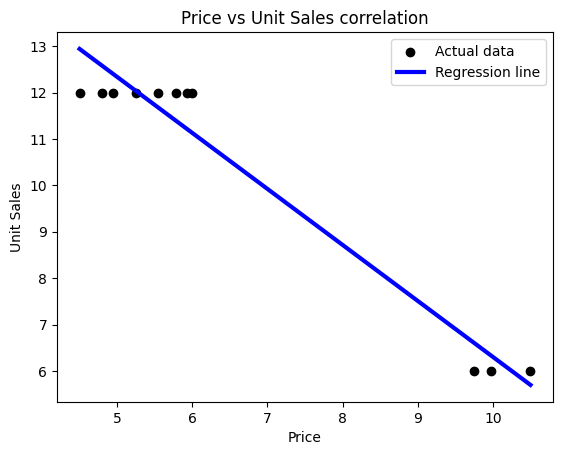

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error,r2_score

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(Price_Elasticity_df.drop(['Sales per Day'],axis=1), Price_Elasticity_df['Sales per Day'], test_size=0.1, random_state=42)

X, y = Price_Elasticity_df.drop(['Sales per Day'],axis=1), Price_Elasticity_df['Sales per Day']

# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X, y)

# Make predictions using the testing data
#y_pred_train = model.predict(X_train)

# Make predictions using the testing data
y_pred = model.predict(X)

# Print the coefficients
print("Coefficients:", model.coef_[0])
print("Intercept:", model.intercept_)

# Calculate and print the mean squared error
#mape = np.sqrt(np.mean(np.square((y_pred_train - y_train)/y_train)))
#print("Mean Absolute Percentage Error (Train) :", mape)

# Calculate and print the mean squared error
#mape = np.sqrt(np.mean(np.square((y_pred - y_test)/y_test)))
#print("Mean Absolute Percentage Error (Test) :", mape)

# Calculate and print the mean squared error
rmspe = np.sqrt(np.mean(np.square((y_pred - y)/y)))
print("Root Mean Sqaured Percentage Error :", rmspe)

# Calculate and print the mean squared error
mape = np.mean(np.abs((y_pred - y)/y))
print("Mean Absolute Percentage Error :", mape)

# Calculate and print the R^2 score
r2 = r2_score(y, y_pred)
print("R^2 Score:", r2)

# Plot the results
plt.scatter(X['Price'], y, color='black', label='Actual data')

# Plot the regression line using the coefficients and intercept
X_range = np.linspace(X['Price'].min(), X['Price'].max(), 100).reshape(-1, 1)
y_range = model.coef_[0] * X_range + model.intercept_
plt.plot(X_range, y_range, color='blue', linewidth=3, label='Regression line')

plt.xlabel('Price')
plt.ylabel('Unit Sales')
plt.title('Price vs Unit Sales correlation')
plt.legend()
plt.show()

In [14]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

X, y = Price_Elasticity_df.drop(['Sales per Day'],axis=1), Price_Elasticity_df['Sales per Day']

# Fit the regression model
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

# Print the summary which includes the p-values
print(results.summary())

# Get p-values directly
p_values = results.pvalues
print("P-values:\n", p_values)

                            OLS Regression Results                            
Dep. Variable:          Sales per Day   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     177.7
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           3.13e-07
Time:                        12:06:17   Log-Likelihood:                -9.7423
No. Observations:                  11   AIC:                             23.48
Df Residuals:                       9   BIC:                             24.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3722      0.632     29.080      0.0

C:\Users\abhij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  k, _ = kurtosistest(a, axis)


### Margin Optimizer Design

Sales = coeff * Price + intercept -> y = mx + c1

Total Margin = M = Sales * (Price - Cost) = y * (x - C2) = (mx + c1) * (x - c2) : 

M = (mx + c1) * (x - c2)

M = mx^2 + c1x - mC2x - c1C2

//

Differential calculus with Price (x) w.r.t Margin (M) : 

M' = 2mx + (c1 - mC)

To find maxima, we equate it to 0 : 

M' = 2mx + (c1 - mC) = 0 
-> (mC - c1) = 2mx ->
x = (mC - c1)/2m

Thus optimal price point to maxize margin = (coeff * Cost - Intercept)/(2*coeff)

In [ ]:
Dynamic_Pricing  = Price_Elasticity_raw_2019_20.filter((col("Item Description")==Item_Description)).sort("Date","Invoice/Item Number").toPandas()
Dynamic_Pricing

,Invoice/Item Number,Date,Vendor Name,Category,Category Name,Item Number,Item Description,State Bottle Retail,Bottles Sold,State Bottle Cost
0,INV-11840400034,2018-05-02 00:00:00,DEHNER DISTILLERY,1041100,American Dry Gins,29423,Blue Ox Gin,9.75,6,6.5
1,INV-11869000096,2018-05-03 00:00:00,DEHNER DISTILLERY,1041100,American Dry Gins,29422,Blue Ox Gin,5.25,2,3.5
2,INV-11916900007,2018-05-07 00:00:00,DEHNER DISTILLERY,1041100,American Dry Gins,29421,Blue Ox Gin,4.50,12,3.0
3,INV-11931700004,2018-05-07 00:00:00,DEHNER DISTILLERY,1041100,American Dry Gins,29422,Blue Ox Gin,5.25,12,3.5
4,INV-11952600030,2018-05-08 00:00:00,DEHNER DISTILLERY,1041100,American Dry Gins,29421,Blue Ox Gin,4.50,3,3.0
...,...,...,...,...,...,...,...,...,...,...
1006,INV-30525500022,2020-09-25 00:00:00,JDSO INC / Red Boot Distillery,1041100,American Dry Gins,29421,Blue Ox Gin,5.25,12,3.5
1007,INV-30648600018,2020-09-30 00:00:00,JDSO INC / Red Boot Distillery,1041100,American Dry Gins,29423,Blue Ox Gin,10.50,6,7.0
1008,INV-30650900010,2020-09-30 00:00:00,JDSO INC / Red Boot Distillery,1041100,American Dry Gins,29421,Blue Ox Gin,5.25,2,3.5
1009,INV-30666300021,2020-09-30 00:00:00,JDSO INC / Red Boot Distillery,1041100,American Dry Gins,29422,Blue Ox Gin,6.00,12,4.0


In [16]:
cost = Dynamic_Pricing['State Bottle Cost'].iloc[-1]
cost

4.0

In [17]:
Current_Price = Dynamic_Pricing['State Bottle Retail'].iloc[-1]
Current_Price

6.0

In [18]:
Optimal_Price = (results.params[1]*cost - results.params[0])/(2*results.params[1])
Optimal_Price

9.611120993307498

In [19]:
Current_Sales = Dynamic_Pricing['Bottles Sold'].iloc[-1]
Current_Sales

12

In [20]:
Optimal_Sales = results.params[1]* Optimal_Price + results.params[0]
Optimal_Sales

6.772220456774939

In [21]:
Current_Margin = ((Current_Price - cost)*Current_Sales)
Current_Margin

24.0

In [22]:
Optimal_Margin = ((Optimal_Price - cost)*Optimal_Sales)
Optimal_Margin

37.999748376316354

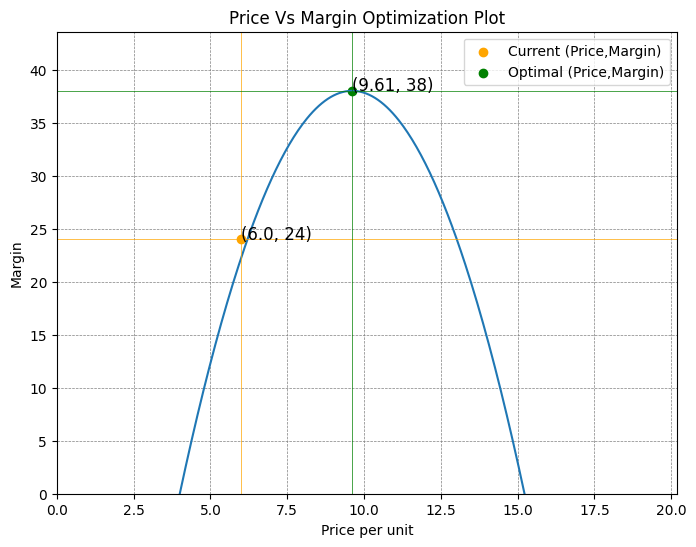

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parabolic function
def parabolic_function(x,m,c1,C2):
    return (m*(x**2) + c1*x - m*C2*x - c1*C2)

# Generate x values
x = np.linspace(0, Optimal_Price*2, 400)

# Compute y values
y = parabolic_function(x,results.params[1],results.params[0],cost)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Price Vs Margin Optimization Plot')
plt.xlabel('Price per unit')
plt.ylabel('Margin')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.scatter(Current_Price,Current_Margin,label="Current (Price,Margin)",color='orange')
plt.text(Current_Price, Current_Margin, f'({round(Current_Price,2)}, {int(round(Current_Margin,0))})', fontsize=12)

Optimal_Margin = parabolic_function(Optimal_Price,results.params[1],results.params[0],cost)
plt.scatter(Optimal_Price,Optimal_Margin,label="Optimal (Price,Margin)",color='green')
plt.text(Optimal_Price, Optimal_Margin, f'({round(Optimal_Price,2)}, {int(round(Optimal_Margin,0))})', fontsize=12)

plt.axhline(Current_Margin, color='orange',linewidth=0.5)
plt.axvline(Current_Price, color='orange',linewidth=0.5)

plt.axhline(Optimal_Margin, color='green',linewidth=0.5)
plt.axvline(Optimal_Price, color='green',linewidth=0.5)


plt.xlim(left=0) 
plt.ylim(bottom=0) 


plt.legend()
plt.show()


Thus, 9.61 is the optimal price point for optimal margin. 

Lets compare it with observed margins for the same product, at same cost

In [ ]:
Real_Observation_with_Optimal_Price_for_same_cost = \
Dynamic_Pricing[Dynamic_Pricing["State Bottle Cost"] == cost] \
[["Date","State Bottle Retail","State Bottle Cost","Bottles Sold"]]

In [25]:
Real_Observation_with_Optimal_Price_for_same_cost['State Bottle Margin'] = Real_Observation_with_Optimal_Price_for_same_cost['State Bottle Retail'] - Real_Observation_with_Optimal_Price_for_same_cost['State Bottle Cost']
Real_Observation_with_Optimal_Price_for_same_cost['Total Margin'] = Real_Observation_with_Optimal_Price_for_same_cost['State Bottle Margin'] * Real_Observation_with_Optimal_Price_for_same_cost['Bottles Sold']
Real_Observation_with_Optimal_Price_for_same_cost.sort_values('Date')

,Date,State Bottle Retail,State Bottle Cost,Bottles Sold,State Bottle Margin,Total Margin
978,2020-09-01 00:00:00,6.0,4.0,12,2.0,24.0
981,2020-09-08 00:00:00,6.0,4.0,24,2.0,48.0
982,2020-09-08 00:00:00,6.0,4.0,12,2.0,24.0
983,2020-09-09 00:00:00,6.0,4.0,12,2.0,24.0
985,2020-09-14 00:00:00,6.0,4.0,12,2.0,24.0
988,2020-09-16 00:00:00,6.0,4.0,12,2.0,24.0
990,2020-09-16 00:00:00,6.0,4.0,12,2.0,24.0
991,2020-09-17 00:00:00,6.0,4.0,24,2.0,48.0
992,2020-09-17 00:00:00,6.0,4.0,36,2.0,72.0
995,2020-09-17 00:00:00,6.0,4.0,2,2.0,4.0


In [26]:
Real_Observation_with_Optimal_Price_for_same_cost.describe()

,State Bottle Retail,State Bottle Cost,Bottles Sold,State Bottle Margin,Total Margin
count,16.0,16.0,16.000000,16.0,16.000000
mean,6.0,4.0,15.125000,2.0,30.250000
std,0.0,0.0,7.965551,0.0,15.931102
min,6.0,4.0,2.000000,2.0,4.000000
25%,6.0,4.0,12.000000,2.0,24.000000
50%,6.0,4.0,12.000000,2.0,24.000000
75%,6.0,4.0,15.000000,2.0,30.000000
max,6.0,4.0,36.000000,2.0,72.000000


# Thus, we can conclude that for a cost of 4 , price must be increased from 6 to 9.61 for optimal margin (38) that would exceed current median margin (24) by about 60%